# Transformer Example 

In [1]:
import pandas as pd 
import numpy as np 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

## Resourcs

* https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/
* https://keras.io/examples/nlp/text_classification_with_transformer/
* https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
* https://arxiv.org/abs/1706.03762
* https://www.tensorflow.org/text/tutorials/transformer
* https://www.youtube.com/watch?v=dichIcUZfOw


## Transformer

![transformer](https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png)

![multihead](https://miro.medium.com/max/4548/1*ETe4WrKJ1lS1MKDgBPIM0g.png)

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, key_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(key_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs,inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Positional encoding



$$
PE_{(pos,2i)} = \sin (pos/10000^{2i/d_{model}})
$$


$$
PE_{(pos,2i+1)} = \cos (pos/10000^{2i/d_{model}})
$$

In [3]:
class PositionEmbedding(layers.Layer):
    def __init__(self,n,d):
        super(PositionEmbedding, self).__init__()
        self.n, self.d = n, d
        self.pos_encoding = self.positional_encoding(n,d)
        
    def get_angles(self,pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self,position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, x):
        x += self.pos_encoding[:, :self.n, :]
        return x 

In [4]:
def getModel(input_shape=(50)):
    inputs = tf.keras.Input(input_shape)
    
    pos_embed = PositionEmbedding(10,5)
    transformer = TransformerBlock(5,10,10)
    
    # reshape seq of len 50 into 10 seq of len 5 each
    x = tf.keras.layers.Reshape((10,5))(inputs)
    x = pos_embed(x)
    x = transformer(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    yh = layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs,yh)
    print(model.summary())
    return model

## Demo 

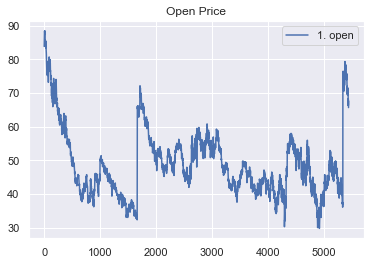

In [5]:
df = pd.read_csv('stock_data.csv')
df['1. open'].plot(title='Open Price')
plt.legend()

In [6]:
N_TEST = 100
BATCH_SIZE = 12
N_INPUT = 50

train_series = df['1. open'].iloc[:].values
test_series = df['1. open'].iloc[N_TEST:].values

train_generator = TimeseriesGenerator(train_series, train_series, length=N_INPUT , batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(test_series, test_series, length=N_INPUT , batch_size=BATCH_SIZE)

In [7]:
model = getModel()
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer=opt,loss=tf.keras.losses.MeanSquaredError(),metrics=['MSE'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 5)             0         
_________________________________________________________________
position_embedding (Position (None, 10, 5)             0         
_________________________________________________________________
transformer_block (Transform (None, 10, 5)             1290      
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6     

In [8]:
history = model.fit(train_generator, steps_per_epoch=len(train_generator),epochs=100)

Epoch 1/100
449/449 [==============================] - 2s 2ms/step - loss: 1820.2996 - MSE: 1820.2996
Epoch 2/100
449/449 [==============================] - 1s 2ms/step - loss: 1047.1652 - MSE: 1047.1652
Epoch 3/100
449/449 [==============================] - 1s 2ms/step - loss: 428.9144 - MSE: 428.9144
Epoch 4/100
449/449 [==============================] - 1s 2ms/step - loss: 187.6009 - MSE: 187.6009
Epoch 5/100
449/449 [==============================] - 1s 2ms/step - loss: 141.0424 - MSE: 141.0424
Epoch 6/100
449/449 [==============================] - 1s 2ms/step - loss: 137.1524 - MSE: 137.1524
Epoch 7/100
449/449 [==============================] - 1s 2ms/step - loss: 139.6847 - MSE: 139.6847
Epoch 8/100
449/449 [==============================] - 1s 3ms/step - loss: 138.8815 - MSE: 138.8815
Epoch 9/100
449/449 [==============================] - 1s 3ms/step - loss: 137.4422 - MSE: 137.4422
Epoch 10/100
449/449 [==============================] - 1s 3ms/step - loss: 137.8412 - MSE: 137.

449/449 [==============================] - 1s 3ms/step - loss: 54.2307 - MSE: 54.2307
Epoch 83/100
449/449 [==============================] - 1s 3ms/step - loss: 52.0711 - MSE: 52.0711
Epoch 84/100
449/449 [==============================] - 1s 3ms/step - loss: 52.4195 - MSE: 52.4195
Epoch 85/100
449/449 [==============================] - 1s 3ms/step - loss: 53.1290 - MSE: 53.1290
Epoch 86/100
449/449 [==============================] - 1s 3ms/step - loss: 56.3670 - MSE: 56.3670
Epoch 87/100
449/449 [==============================] - 1s 3ms/step - loss: 50.6933 - MSE: 50.6933
Epoch 88/100
449/449 [==============================] - 1s 3ms/step - loss: 52.4977 - MSE: 52.4977
Epoch 89/100
449/449 [==============================] - 1s 2ms/step - loss: 55.5259 - MSE: 55.5259
Epoch 90/100
449/449 [==============================] - 1s 3ms/step - loss: 50.2507 - MSE: 50.2507
Epoch 91/100
449/449 [==============================] - 1s 2ms/step - loss: 48.8839 - MSE: 48.8839
Epoch 92/100
449/449 [=

In [9]:
yh = model.predict(test_generator)

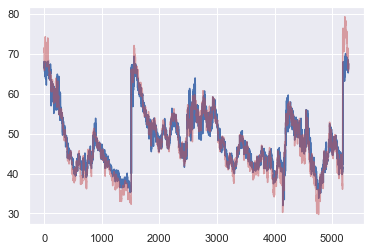

In [10]:
plt.plot(range(0,yh.shape[0]),yh.flatten())
plt.plot(range(0,yh.shape[0]),test_series.flatten()[test_series.shape[0]-yh.shape[0]:],color='r',alpha=.5)